# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

#helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

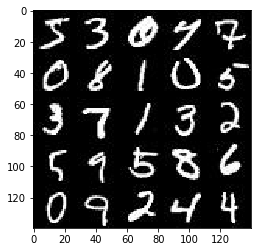

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

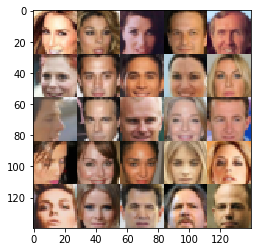

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    in_learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return input_real, input_z, in_learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator

Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False, alpha=0.08, stddev=0.01):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Layer 1 in: 28x28x(1|3)
        layer_1 = tf.layers.conv2d(images, 32, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        # Layer 1 out: 14x14x32
        
        # Layer 2: 14x14x32
        layer_2 = tf.layers.conv2d(layer_1, 64, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_2 = tf.layers.batch_normalization(layer_2, training=True)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        # Layer 2 out: 7x7x64
        
        layer_3 = tf.layers.conv2d(layer_2, 128, 5, 2, padding='same',  kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_3 = tf.layers.batch_normalization(layer_3, training=True)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        # Layer 3 out: 4x4x128
        
        layer_4 = tf.layers.conv2d(layer_3, 256, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_4 = tf.layers.batch_normalization(layer_4, training=True)
        layer_4 = tf.maximum(alpha * layer_4, layer_4)
        # Layer 4 out: 2x2x256
        
        flattened = tf.reshape(layer_4, (-1, 2*2*256))
        logits = tf.layers.dense(flattened, 1, kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.sigmoid(logits)
        
        return output, logits
        
        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.08, stddev=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # Layer 1 in: 7x7x256
        layer_1 = tf.layers.dense(z, 4 * 4 * 512)
        layer_1 = tf.reshape(layer_1, (-1, 4, 4, 512))
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        # Layer 1 out: 4x4x512
        
        layer_2 = tf.layers.conv2d_transpose(layer_1, 128, 4, 1, padding='valid', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        # Layer 2 out: 8x8x128
        
        layer_3 = tf.layers.conv2d_transpose(layer_2, 64, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_3 = tf.layers.batch_normalization(layer_3, training=is_train)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        # Layer 3 out: 16x16x64
        
        layer_4 = tf.layers.conv2d_transpose(layer_3, 32, 5, 2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_4 = tf.layers.batch_normalization(layer_4, training=is_train)
        layer_4 = tf.maximum(alpha * layer_4, layer_4)
        # Layer 4 out: 32x32x32
        
        logits = tf.layers.conv2d_transpose(layer_4, out_channel_dim, 3, 1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.tanh(logits)
        
        return output
        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_logits_real) * 0.9))
    dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_logits_fake)))
    dis_loss = dis_loss_real + dis_loss_fake
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_logits_fake)))
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        dis_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
        return dis_train_ops, gen_train_ops


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, in_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    dis_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    dis_ops, gen_ops = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    steps = 0
    
    print_every = 10
    show_every = 200
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(dis_ops, feed_dict={ input_real: batch_images, input_z: batch_z, in_learning_rate: learning_rate })
                _ = sess.run(gen_ops, feed_dict={ input_z: batch_z, in_learning_rate: learning_rate })
                
                if steps % print_every == 0:
                    dis_loss_train = dis_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    gen_loss_train = gen_loss.eval({
                        input_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(dis_loss_train),
                         "Generator Loss: {:.4f}".format(gen_loss_train))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    
            
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3622... Generator Loss: 3.6665
Epoch 1/2... Discriminator Loss: 1.3027... Generator Loss: 0.7596
Epoch 1/2... Discriminator Loss: 1.5214... Generator Loss: 2.4397
Epoch 1/2... Discriminator Loss: 0.9763... Generator Loss: 0.9447
Epoch 1/2... Discriminator Loss: 0.3862... Generator Loss: 3.7818
Epoch 1/2... Discriminator Loss: 0.3797... Generator Loss: 4.4095
Epoch 1/2... Discriminator Loss: 1.5113... Generator Loss: 0.4185
Epoch 1/2... Discriminator Loss: 0.7111... Generator Loss: 1.3467
Epoch 1/2... Discriminator Loss: 0.3453... Generator Loss: 4.4724
Epoch 1/2... Discriminator Loss: 0.4102... Generator Loss: 3.3859
Epoch 1/2... Discriminator Loss: 0.3335... Generator Loss: 5.3012
Epoch 1/2... Discriminator Loss: 1.4397... Generator Loss: 0.4536
Epoch 1/2... Discriminator Loss: 1.5519... Generator Loss: 0.3877
Epoch 1/2... Discriminator Loss: 0.6963... Generator Loss: 1.6278
Epoch 1/2... Discriminator Loss: 0.8807... Generator Loss: 1.1787
Epoch 1/2.

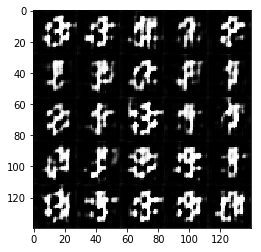

Epoch 1/2... Discriminator Loss: 0.7495... Generator Loss: 1.2318
Epoch 1/2... Discriminator Loss: 1.3076... Generator Loss: 0.6196
Epoch 1/2... Discriminator Loss: 0.6578... Generator Loss: 1.8307
Epoch 1/2... Discriminator Loss: 1.2001... Generator Loss: 0.6384
Epoch 1/2... Discriminator Loss: 0.8631... Generator Loss: 1.3287
Epoch 1/2... Discriminator Loss: 0.6506... Generator Loss: 1.5284
Epoch 1/2... Discriminator Loss: 0.6355... Generator Loss: 1.7285
Epoch 1/2... Discriminator Loss: 1.0887... Generator Loss: 0.7465
Epoch 1/2... Discriminator Loss: 1.6607... Generator Loss: 0.3624
Epoch 1/2... Discriminator Loss: 1.1448... Generator Loss: 1.9658
Epoch 1/2... Discriminator Loss: 0.9435... Generator Loss: 1.0177
Epoch 1/2... Discriminator Loss: 0.8884... Generator Loss: 2.3784
Epoch 1/2... Discriminator Loss: 0.7527... Generator Loss: 2.0725
Epoch 1/2... Discriminator Loss: 0.6156... Generator Loss: 1.9930
Epoch 1/2... Discriminator Loss: 0.9611... Generator Loss: 1.4596
Epoch 1/2.

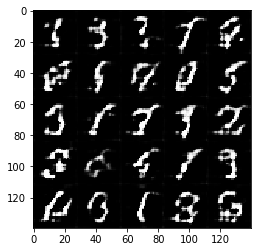

Epoch 1/2... Discriminator Loss: 0.9300... Generator Loss: 0.9555
Epoch 1/2... Discriminator Loss: 0.8898... Generator Loss: 1.6298
Epoch 1/2... Discriminator Loss: 1.3194... Generator Loss: 0.5626
Epoch 1/2... Discriminator Loss: 1.1229... Generator Loss: 0.7469
Epoch 1/2... Discriminator Loss: 0.6542... Generator Loss: 1.9380
Epoch 1/2... Discriminator Loss: 1.4011... Generator Loss: 0.7584
Epoch 1/2... Discriminator Loss: 1.1398... Generator Loss: 0.7262
Epoch 1/2... Discriminator Loss: 1.4525... Generator Loss: 0.4719
Epoch 1/2... Discriminator Loss: 1.1463... Generator Loss: 0.8510
Epoch 1/2... Discriminator Loss: 1.1468... Generator Loss: 0.7045
Epoch 1/2... Discriminator Loss: 1.2326... Generator Loss: 1.3907
Epoch 1/2... Discriminator Loss: 0.9403... Generator Loss: 1.4146
Epoch 1/2... Discriminator Loss: 1.1505... Generator Loss: 1.3291
Epoch 1/2... Discriminator Loss: 1.0246... Generator Loss: 0.8243
Epoch 1/2... Discriminator Loss: 1.7604... Generator Loss: 0.2965
Epoch 1/2.

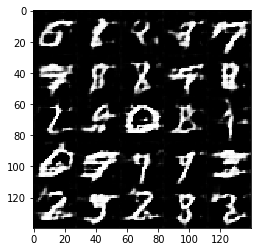

Epoch 1/2... Discriminator Loss: 1.0131... Generator Loss: 1.0308
Epoch 1/2... Discriminator Loss: 1.1495... Generator Loss: 0.7093
Epoch 1/2... Discriminator Loss: 1.4712... Generator Loss: 2.8820
Epoch 1/2... Discriminator Loss: 0.9183... Generator Loss: 0.9805
Epoch 1/2... Discriminator Loss: 1.4561... Generator Loss: 0.4790
Epoch 1/2... Discriminator Loss: 1.9139... Generator Loss: 0.3317
Epoch 1/2... Discriminator Loss: 1.1344... Generator Loss: 0.7474
Epoch 1/2... Discriminator Loss: 1.2390... Generator Loss: 0.7230
Epoch 1/2... Discriminator Loss: 0.8596... Generator Loss: 1.6386
Epoch 1/2... Discriminator Loss: 1.4521... Generator Loss: 1.9196
Epoch 1/2... Discriminator Loss: 1.2344... Generator Loss: 0.5874
Epoch 1/2... Discriminator Loss: 1.5318... Generator Loss: 0.4838
Epoch 1/2... Discriminator Loss: 0.8199... Generator Loss: 1.2132
Epoch 1/2... Discriminator Loss: 0.9551... Generator Loss: 0.9664
Epoch 1/2... Discriminator Loss: 1.1980... Generator Loss: 0.8625
Epoch 1/2.

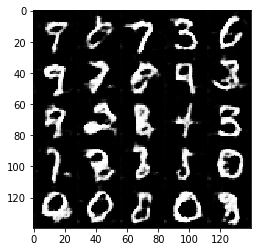

Epoch 1/2... Discriminator Loss: 1.9685... Generator Loss: 0.3021
Epoch 1/2... Discriminator Loss: 0.6225... Generator Loss: 1.8663
Epoch 1/2... Discriminator Loss: 1.0843... Generator Loss: 3.5798
Epoch 1/2... Discriminator Loss: 0.8559... Generator Loss: 1.0791
Epoch 1/2... Discriminator Loss: 0.8457... Generator Loss: 1.5927
Epoch 1/2... Discriminator Loss: 0.9240... Generator Loss: 1.0553
Epoch 1/2... Discriminator Loss: 1.3649... Generator Loss: 0.7382
Epoch 1/2... Discriminator Loss: 1.3149... Generator Loss: 0.5812
Epoch 1/2... Discriminator Loss: 1.0299... Generator Loss: 1.3833
Epoch 1/2... Discriminator Loss: 1.4314... Generator Loss: 0.4687
Epoch 1/2... Discriminator Loss: 1.9153... Generator Loss: 0.2552
Epoch 1/2... Discriminator Loss: 0.9494... Generator Loss: 1.1725
Epoch 1/2... Discriminator Loss: 1.3304... Generator Loss: 0.5206
Epoch 2/2... Discriminator Loss: 1.2482... Generator Loss: 0.6744
Epoch 2/2... Discriminator Loss: 0.8558... Generator Loss: 1.5340
Epoch 2/2.

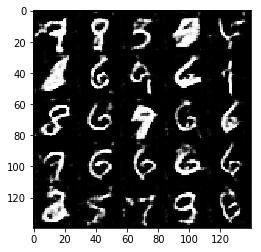

Epoch 2/2... Discriminator Loss: 1.0790... Generator Loss: 0.8178
Epoch 2/2... Discriminator Loss: 1.0708... Generator Loss: 0.8330
Epoch 2/2... Discriminator Loss: 0.7900... Generator Loss: 1.4884
Epoch 2/2... Discriminator Loss: 1.7839... Generator Loss: 0.2929
Epoch 2/2... Discriminator Loss: 0.9009... Generator Loss: 1.0121
Epoch 2/2... Discriminator Loss: 1.0553... Generator Loss: 0.7877
Epoch 2/2... Discriminator Loss: 0.8407... Generator Loss: 1.1773
Epoch 2/2... Discriminator Loss: 1.7793... Generator Loss: 0.3011
Epoch 2/2... Discriminator Loss: 1.5839... Generator Loss: 2.6935
Epoch 2/2... Discriminator Loss: 0.9387... Generator Loss: 1.0348
Epoch 2/2... Discriminator Loss: 1.0105... Generator Loss: 0.7921
Epoch 2/2... Discriminator Loss: 0.7474... Generator Loss: 1.2217
Epoch 2/2... Discriminator Loss: 1.4024... Generator Loss: 0.4872
Epoch 2/2... Discriminator Loss: 1.6323... Generator Loss: 0.3588
Epoch 2/2... Discriminator Loss: 1.4369... Generator Loss: 0.4991
Epoch 2/2.

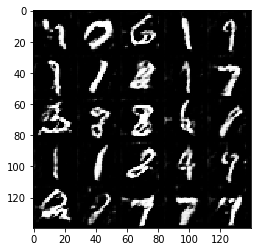

Epoch 2/2... Discriminator Loss: 0.7806... Generator Loss: 1.2467
Epoch 2/2... Discriminator Loss: 0.9473... Generator Loss: 0.9278
Epoch 2/2... Discriminator Loss: 2.1977... Generator Loss: 0.2769
Epoch 2/2... Discriminator Loss: 1.6694... Generator Loss: 0.3874
Epoch 2/2... Discriminator Loss: 0.8868... Generator Loss: 1.4908
Epoch 2/2... Discriminator Loss: 0.9279... Generator Loss: 0.9187
Epoch 2/2... Discriminator Loss: 1.4295... Generator Loss: 0.4503
Epoch 2/2... Discriminator Loss: 2.1327... Generator Loss: 0.2859
Epoch 2/2... Discriminator Loss: 1.5522... Generator Loss: 0.3970
Epoch 2/2... Discriminator Loss: 1.1492... Generator Loss: 0.7343
Epoch 2/2... Discriminator Loss: 1.0958... Generator Loss: 0.7168
Epoch 2/2... Discriminator Loss: 1.5268... Generator Loss: 0.4449
Epoch 2/2... Discriminator Loss: 1.3547... Generator Loss: 0.6720
Epoch 2/2... Discriminator Loss: 1.0015... Generator Loss: 1.8292
Epoch 2/2... Discriminator Loss: 1.0732... Generator Loss: 1.1114
Epoch 2/2.

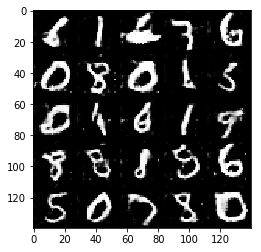

Epoch 2/2... Discriminator Loss: 1.1091... Generator Loss: 0.7191
Epoch 2/2... Discriminator Loss: 1.0387... Generator Loss: 1.6263
Epoch 2/2... Discriminator Loss: 2.0126... Generator Loss: 0.2305
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.4717
Epoch 2/2... Discriminator Loss: 1.7498... Generator Loss: 0.3208
Epoch 2/2... Discriminator Loss: 1.2886... Generator Loss: 0.6197
Epoch 2/2... Discriminator Loss: 1.0867... Generator Loss: 0.7117
Epoch 2/2... Discriminator Loss: 2.3143... Generator Loss: 0.1790
Epoch 2/2... Discriminator Loss: 1.7078... Generator Loss: 0.3214
Epoch 2/2... Discriminator Loss: 0.9504... Generator Loss: 0.8762
Epoch 2/2... Discriminator Loss: 1.7468... Generator Loss: 0.3252
Epoch 2/2... Discriminator Loss: 1.2182... Generator Loss: 0.5879
Epoch 2/2... Discriminator Loss: 1.6461... Generator Loss: 0.3573
Epoch 2/2... Discriminator Loss: 1.5458... Generator Loss: 0.3901
Epoch 2/2... Discriminator Loss: 1.1295... Generator Loss: 0.6630
Epoch 2/2.

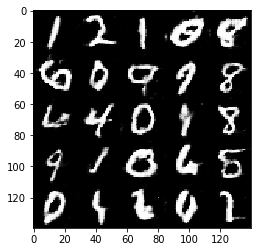

Epoch 2/2... Discriminator Loss: 1.4922... Generator Loss: 0.4172
Epoch 2/2... Discriminator Loss: 1.7928... Generator Loss: 0.5321
Epoch 2/2... Discriminator Loss: 1.2823... Generator Loss: 0.5987
Epoch 2/2... Discriminator Loss: 1.6279... Generator Loss: 0.3748
Epoch 2/2... Discriminator Loss: 0.8604... Generator Loss: 1.0655
Epoch 2/2... Discriminator Loss: 0.9052... Generator Loss: 1.0217
Epoch 2/2... Discriminator Loss: 0.9492... Generator Loss: 1.0067
Epoch 2/2... Discriminator Loss: 1.0468... Generator Loss: 1.5503
Epoch 2/2... Discriminator Loss: 1.0880... Generator Loss: 0.7284
Epoch 2/2... Discriminator Loss: 1.8398... Generator Loss: 0.3138
Epoch 2/2... Discriminator Loss: 1.1920... Generator Loss: 0.6339
Epoch 2/2... Discriminator Loss: 1.7314... Generator Loss: 0.3141
Epoch 2/2... Discriminator Loss: 1.0450... Generator Loss: 1.0272
Epoch 2/2... Discriminator Loss: 1.3606... Generator Loss: 0.5096
Epoch 2/2... Discriminator Loss: 0.8740... Generator Loss: 1.2515
Epoch 2/2.

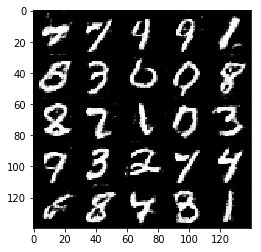

Epoch 2/2... Discriminator Loss: 1.4521... Generator Loss: 0.5246
Epoch 2/2... Discriminator Loss: 1.8185... Generator Loss: 0.2846
Epoch 2/2... Discriminator Loss: 1.3028... Generator Loss: 0.5853
Epoch 2/2... Discriminator Loss: 1.4423... Generator Loss: 0.4506
Epoch 2/2... Discriminator Loss: 1.0335... Generator Loss: 1.1021
Epoch 2/2... Discriminator Loss: 1.4415... Generator Loss: 0.5477
Epoch 2/2... Discriminator Loss: 0.9355... Generator Loss: 0.9227


In [14]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/3... Discriminator Loss: 1.5728... Generator Loss: 0.3561
Epoch 1/3... Discriminator Loss: 1.0988... Generator Loss: 0.8366
Epoch 1/3... Discriminator Loss: 1.8725... Generator Loss: 0.2943
Epoch 1/3... Discriminator Loss: 1.4198... Generator Loss: 0.4785
Epoch 1/3... Discriminator Loss: 0.7018... Generator Loss: 1.5367
Epoch 1/3... Discriminator Loss: 1.3363... Generator Loss: 0.8138
Epoch 1/3... Discriminator Loss: 1.3894... Generator Loss: 0.7003
Epoch 1/3... Discriminator Loss: 1.0709... Generator Loss: 1.5398
Epoch 1/3... Discriminator Loss: 1.6690... Generator Loss: 1.8890
Epoch 1/3... Discriminator Loss: 1.0914... Generator Loss: 1.1098
Epoch 1/3... Discriminator Loss: 1.4266... Generator Loss: 0.5471
Epoch 1/3... Discriminator Loss: 1.2940... Generator Loss: 0.7487
Epoch 1/3... Discriminator Loss: 1.2369... Generator Loss: 1.0985
Epoch 1/3... Discriminator Loss: 1.1475... Generator Loss: 1.0766
Epoch 1/3... Discriminator Loss: 1.3346... Generator Loss: 1.1327
Epoch 1/3.

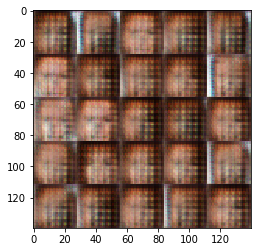

Epoch 1/3... Discriminator Loss: 1.2068... Generator Loss: 1.0026
Epoch 1/3... Discriminator Loss: 1.2009... Generator Loss: 0.7749
Epoch 1/3... Discriminator Loss: 1.2051... Generator Loss: 0.9114
Epoch 1/3... Discriminator Loss: 1.4073... Generator Loss: 0.5525
Epoch 1/3... Discriminator Loss: 1.2960... Generator Loss: 0.7597
Epoch 1/3... Discriminator Loss: 1.1843... Generator Loss: 0.8295
Epoch 1/3... Discriminator Loss: 1.2526... Generator Loss: 1.1547
Epoch 1/3... Discriminator Loss: 1.2024... Generator Loss: 1.1177
Epoch 1/3... Discriminator Loss: 1.3022... Generator Loss: 1.0243
Epoch 1/3... Discriminator Loss: 1.2339... Generator Loss: 0.7940
Epoch 1/3... Discriminator Loss: 1.1424... Generator Loss: 0.9527
Epoch 1/3... Discriminator Loss: 1.0639... Generator Loss: 0.9617
Epoch 1/3... Discriminator Loss: 1.2161... Generator Loss: 0.9914
Epoch 1/3... Discriminator Loss: 1.3912... Generator Loss: 0.6859
Epoch 1/3... Discriminator Loss: 1.2649... Generator Loss: 0.9347
Epoch 1/3.

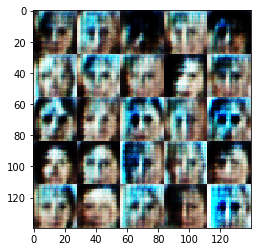

Epoch 1/3... Discriminator Loss: 1.3520... Generator Loss: 0.7898
Epoch 1/3... Discriminator Loss: 1.3065... Generator Loss: 0.6989
Epoch 1/3... Discriminator Loss: 1.5000... Generator Loss: 0.4399
Epoch 1/3... Discriminator Loss: 1.3537... Generator Loss: 0.8049
Epoch 1/3... Discriminator Loss: 1.3252... Generator Loss: 1.0258
Epoch 1/3... Discriminator Loss: 1.1814... Generator Loss: 1.0104
Epoch 1/3... Discriminator Loss: 1.3062... Generator Loss: 0.7648
Epoch 1/3... Discriminator Loss: 1.2501... Generator Loss: 0.6348
Epoch 1/3... Discriminator Loss: 1.0038... Generator Loss: 1.2940
Epoch 1/3... Discriminator Loss: 1.1090... Generator Loss: 0.9761
Epoch 1/3... Discriminator Loss: 1.2727... Generator Loss: 0.8085
Epoch 1/3... Discriminator Loss: 1.1761... Generator Loss: 0.6936
Epoch 1/3... Discriminator Loss: 1.1044... Generator Loss: 1.6591
Epoch 1/3... Discriminator Loss: 1.3596... Generator Loss: 0.6557
Epoch 1/3... Discriminator Loss: 1.4231... Generator Loss: 0.5520
Epoch 1/3.

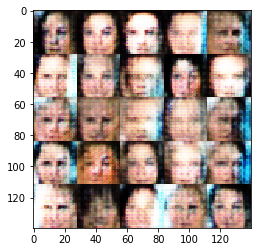

Epoch 1/3... Discriminator Loss: 1.1564... Generator Loss: 0.8601
Epoch 1/3... Discriminator Loss: 1.1582... Generator Loss: 0.7427
Epoch 1/3... Discriminator Loss: 1.2317... Generator Loss: 0.9065
Epoch 1/3... Discriminator Loss: 1.0758... Generator Loss: 0.8718
Epoch 1/3... Discriminator Loss: 1.2290... Generator Loss: 0.7599
Epoch 1/3... Discriminator Loss: 1.3632... Generator Loss: 1.6396
Epoch 1/3... Discriminator Loss: 1.2126... Generator Loss: 1.1304
Epoch 1/3... Discriminator Loss: 1.2511... Generator Loss: 0.8883
Epoch 1/3... Discriminator Loss: 1.3723... Generator Loss: 0.4810
Epoch 1/3... Discriminator Loss: 1.1929... Generator Loss: 0.7208
Epoch 1/3... Discriminator Loss: 1.2664... Generator Loss: 1.1100
Epoch 1/3... Discriminator Loss: 1.2553... Generator Loss: 0.7260
Epoch 1/3... Discriminator Loss: 1.1029... Generator Loss: 0.9444
Epoch 1/3... Discriminator Loss: 1.1898... Generator Loss: 0.8638
Epoch 1/3... Discriminator Loss: 1.1712... Generator Loss: 0.8783
Epoch 1/3.

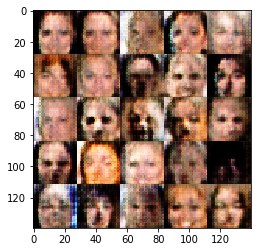

Epoch 1/3... Discriminator Loss: 1.2279... Generator Loss: 0.6768
Epoch 1/3... Discriminator Loss: 1.3513... Generator Loss: 0.6371
Epoch 1/3... Discriminator Loss: 1.2295... Generator Loss: 0.7911
Epoch 1/3... Discriminator Loss: 1.3693... Generator Loss: 0.7007
Epoch 1/3... Discriminator Loss: 1.4379... Generator Loss: 0.4766
Epoch 1/3... Discriminator Loss: 1.1514... Generator Loss: 0.8947
Epoch 1/3... Discriminator Loss: 1.3552... Generator Loss: 0.6110
Epoch 1/3... Discriminator Loss: 1.4558... Generator Loss: 0.8806
Epoch 1/3... Discriminator Loss: 1.2622... Generator Loss: 0.8821
Epoch 1/3... Discriminator Loss: 1.2577... Generator Loss: 1.3469
Epoch 1/3... Discriminator Loss: 1.2889... Generator Loss: 0.5712
Epoch 1/3... Discriminator Loss: 1.2047... Generator Loss: 0.9505
Epoch 1/3... Discriminator Loss: 1.3029... Generator Loss: 0.7596
Epoch 1/3... Discriminator Loss: 1.3536... Generator Loss: 0.7609
Epoch 1/3... Discriminator Loss: 1.1096... Generator Loss: 0.9603
Epoch 1/3.

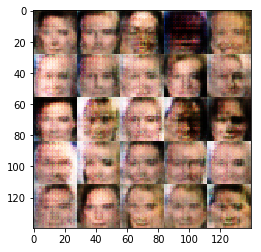

Epoch 1/3... Discriminator Loss: 1.4751... Generator Loss: 0.4527
Epoch 1/3... Discriminator Loss: 1.2264... Generator Loss: 0.6695
Epoch 1/3... Discriminator Loss: 1.3107... Generator Loss: 0.7196
Epoch 1/3... Discriminator Loss: 1.0964... Generator Loss: 1.0097
Epoch 1/3... Discriminator Loss: 1.1076... Generator Loss: 1.0835
Epoch 1/3... Discriminator Loss: 1.3602... Generator Loss: 0.6207
Epoch 1/3... Discriminator Loss: 1.1938... Generator Loss: 0.9084
Epoch 1/3... Discriminator Loss: 1.2192... Generator Loss: 0.7871
Epoch 1/3... Discriminator Loss: 1.1719... Generator Loss: 1.2899
Epoch 1/3... Discriminator Loss: 1.2635... Generator Loss: 0.7286
Epoch 1/3... Discriminator Loss: 1.1168... Generator Loss: 1.0771
Epoch 1/3... Discriminator Loss: 1.1364... Generator Loss: 1.0291
Epoch 1/3... Discriminator Loss: 1.1292... Generator Loss: 0.8830
Epoch 1/3... Discriminator Loss: 1.1251... Generator Loss: 0.8976
Epoch 1/3... Discriminator Loss: 1.1352... Generator Loss: 1.0983
Epoch 1/3.

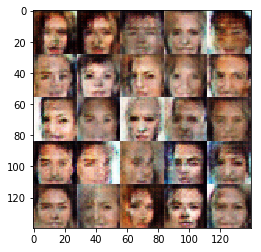

Epoch 1/3... Discriminator Loss: 1.2594... Generator Loss: 0.8598
Epoch 1/3... Discriminator Loss: 1.2986... Generator Loss: 0.7613
Epoch 1/3... Discriminator Loss: 1.1191... Generator Loss: 1.3271
Epoch 1/3... Discriminator Loss: 1.2382... Generator Loss: 0.7530
Epoch 1/3... Discriminator Loss: 1.3076... Generator Loss: 1.0067
Epoch 1/3... Discriminator Loss: 1.3661... Generator Loss: 0.6508
Epoch 1/3... Discriminator Loss: 1.3641... Generator Loss: 0.5566
Epoch 1/3... Discriminator Loss: 1.5034... Generator Loss: 0.4931
Epoch 1/3... Discriminator Loss: 1.1787... Generator Loss: 0.9882
Epoch 1/3... Discriminator Loss: 1.2547... Generator Loss: 0.8776
Epoch 1/3... Discriminator Loss: 1.1986... Generator Loss: 1.0786
Epoch 1/3... Discriminator Loss: 1.3603... Generator Loss: 0.5813
Epoch 1/3... Discriminator Loss: 1.2656... Generator Loss: 0.6688
Epoch 1/3... Discriminator Loss: 1.5184... Generator Loss: 0.4210
Epoch 1/3... Discriminator Loss: 1.2004... Generator Loss: 0.8995
Epoch 1/3.

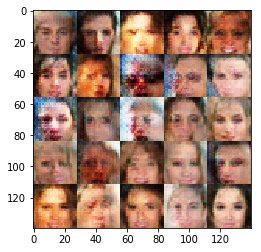

Epoch 1/3... Discriminator Loss: 1.4926... Generator Loss: 0.4804
Epoch 1/3... Discriminator Loss: 1.3653... Generator Loss: 1.2157
Epoch 1/3... Discriminator Loss: 1.1769... Generator Loss: 0.8134
Epoch 1/3... Discriminator Loss: 1.4543... Generator Loss: 0.4897
Epoch 1/3... Discriminator Loss: 1.1558... Generator Loss: 0.8317
Epoch 1/3... Discriminator Loss: 1.1601... Generator Loss: 1.3523
Epoch 1/3... Discriminator Loss: 1.2762... Generator Loss: 0.7590
Epoch 1/3... Discriminator Loss: 1.3102... Generator Loss: 0.8576
Epoch 1/3... Discriminator Loss: 1.1549... Generator Loss: 0.8280
Epoch 1/3... Discriminator Loss: 1.2650... Generator Loss: 0.7432
Epoch 1/3... Discriminator Loss: 1.2907... Generator Loss: 0.7393
Epoch 1/3... Discriminator Loss: 1.1667... Generator Loss: 0.9629
Epoch 1/3... Discriminator Loss: 1.2517... Generator Loss: 0.9908
Epoch 1/3... Discriminator Loss: 1.2195... Generator Loss: 0.6851
Epoch 1/3... Discriminator Loss: 1.2088... Generator Loss: 0.7029
Epoch 1/3.

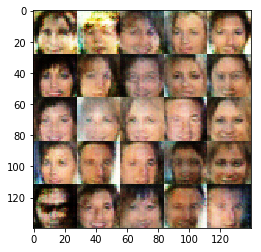

Epoch 1/3... Discriminator Loss: 1.2391... Generator Loss: 0.6301
Epoch 1/3... Discriminator Loss: 1.1558... Generator Loss: 0.8458
Epoch 1/3... Discriminator Loss: 1.1877... Generator Loss: 0.8060
Epoch 1/3... Discriminator Loss: 1.2269... Generator Loss: 0.6697
Epoch 1/3... Discriminator Loss: 1.1766... Generator Loss: 0.7978
Epoch 1/3... Discriminator Loss: 1.2428... Generator Loss: 1.0642
Epoch 1/3... Discriminator Loss: 1.1847... Generator Loss: 1.0654
Epoch 1/3... Discriminator Loss: 1.1281... Generator Loss: 0.9180
Epoch 1/3... Discriminator Loss: 1.2178... Generator Loss: 0.6966
Epoch 1/3... Discriminator Loss: 1.3800... Generator Loss: 0.5489
Epoch 1/3... Discriminator Loss: 1.3117... Generator Loss: 0.5888
Epoch 1/3... Discriminator Loss: 1.2346... Generator Loss: 0.7586
Epoch 1/3... Discriminator Loss: 1.1339... Generator Loss: 0.8645
Epoch 1/3... Discriminator Loss: 1.3463... Generator Loss: 1.0918
Epoch 1/3... Discriminator Loss: 1.7242... Generator Loss: 0.3295
Epoch 1/3.

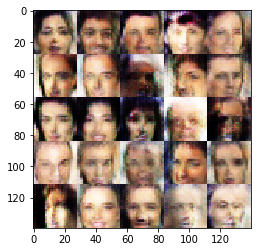

Epoch 1/3... Discriminator Loss: 1.4345... Generator Loss: 0.5292
Epoch 1/3... Discriminator Loss: 1.2144... Generator Loss: 0.9041
Epoch 1/3... Discriminator Loss: 1.3702... Generator Loss: 0.5401
Epoch 1/3... Discriminator Loss: 1.1361... Generator Loss: 0.9691
Epoch 1/3... Discriminator Loss: 1.3785... Generator Loss: 0.6049
Epoch 1/3... Discriminator Loss: 1.3184... Generator Loss: 0.6936
Epoch 1/3... Discriminator Loss: 1.4290... Generator Loss: 0.5210
Epoch 1/3... Discriminator Loss: 1.1750... Generator Loss: 0.8100
Epoch 1/3... Discriminator Loss: 1.4508... Generator Loss: 1.7811
Epoch 1/3... Discriminator Loss: 1.2682... Generator Loss: 0.7132
Epoch 1/3... Discriminator Loss: 1.2319... Generator Loss: 0.7315
Epoch 1/3... Discriminator Loss: 1.3374... Generator Loss: 0.6545
Epoch 1/3... Discriminator Loss: 1.1991... Generator Loss: 0.8851
Epoch 1/3... Discriminator Loss: 1.2679... Generator Loss: 0.6639
Epoch 1/3... Discriminator Loss: 1.2682... Generator Loss: 0.7392
Epoch 1/3.

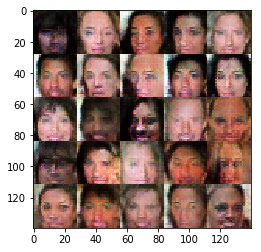

Epoch 1/3... Discriminator Loss: 1.4962... Generator Loss: 0.4964
Epoch 1/3... Discriminator Loss: 1.2148... Generator Loss: 0.8398
Epoch 1/3... Discriminator Loss: 1.2894... Generator Loss: 0.6186
Epoch 1/3... Discriminator Loss: 1.6176... Generator Loss: 0.3549
Epoch 1/3... Discriminator Loss: 1.1357... Generator Loss: 0.9283
Epoch 1/3... Discriminator Loss: 1.1889... Generator Loss: 0.8106
Epoch 1/3... Discriminator Loss: 1.1951... Generator Loss: 0.7795
Epoch 1/3... Discriminator Loss: 1.1491... Generator Loss: 1.1178
Epoch 1/3... Discriminator Loss: 1.2532... Generator Loss: 0.8025
Epoch 1/3... Discriminator Loss: 1.2028... Generator Loss: 0.9478
Epoch 1/3... Discriminator Loss: 1.4177... Generator Loss: 0.5600
Epoch 1/3... Discriminator Loss: 1.2525... Generator Loss: 1.0617
Epoch 1/3... Discriminator Loss: 1.1980... Generator Loss: 0.7610
Epoch 1/3... Discriminator Loss: 1.1607... Generator Loss: 0.8353
Epoch 1/3... Discriminator Loss: 1.3475... Generator Loss: 0.8618
Epoch 1/3.

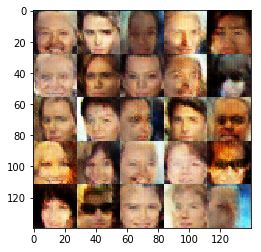

Epoch 1/3... Discriminator Loss: 1.2546... Generator Loss: 0.7825
Epoch 1/3... Discriminator Loss: 1.1327... Generator Loss: 1.0363
Epoch 1/3... Discriminator Loss: 1.3099... Generator Loss: 0.6116
Epoch 1/3... Discriminator Loss: 1.1883... Generator Loss: 0.8777
Epoch 1/3... Discriminator Loss: 1.2017... Generator Loss: 0.7931
Epoch 1/3... Discriminator Loss: 1.4031... Generator Loss: 0.4929
Epoch 1/3... Discriminator Loss: 1.4549... Generator Loss: 0.4487
Epoch 1/3... Discriminator Loss: 1.3692... Generator Loss: 0.6438
Epoch 1/3... Discriminator Loss: 1.1940... Generator Loss: 1.3993
Epoch 1/3... Discriminator Loss: 1.1830... Generator Loss: 1.0258
Epoch 1/3... Discriminator Loss: 1.4319... Generator Loss: 0.4886
Epoch 1/3... Discriminator Loss: 1.2343... Generator Loss: 0.7147
Epoch 1/3... Discriminator Loss: 1.3207... Generator Loss: 0.5673
Epoch 1/3... Discriminator Loss: 1.3530... Generator Loss: 0.5528
Epoch 1/3... Discriminator Loss: 1.1992... Generator Loss: 0.9083
Epoch 1/3.

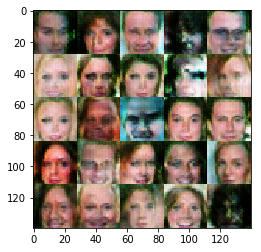

Epoch 1/3... Discriminator Loss: 1.1655... Generator Loss: 0.7769
Epoch 1/3... Discriminator Loss: 1.1869... Generator Loss: 0.6532
Epoch 1/3... Discriminator Loss: 1.2342... Generator Loss: 0.8303
Epoch 1/3... Discriminator Loss: 1.1246... Generator Loss: 0.9548
Epoch 1/3... Discriminator Loss: 1.3198... Generator Loss: 0.6280
Epoch 1/3... Discriminator Loss: 1.4183... Generator Loss: 0.5476
Epoch 1/3... Discriminator Loss: 1.3442... Generator Loss: 1.0131
Epoch 1/3... Discriminator Loss: 1.1822... Generator Loss: 0.7946
Epoch 1/3... Discriminator Loss: 1.2605... Generator Loss: 0.7279
Epoch 1/3... Discriminator Loss: 1.2968... Generator Loss: 0.6903
Epoch 1/3... Discriminator Loss: 1.1295... Generator Loss: 0.8604
Epoch 1/3... Discriminator Loss: 1.3735... Generator Loss: 0.5203
Epoch 1/3... Discriminator Loss: 1.1700... Generator Loss: 0.9695
Epoch 1/3... Discriminator Loss: 1.2278... Generator Loss: 0.6504
Epoch 1/3... Discriminator Loss: 1.1576... Generator Loss: 1.1625
Epoch 1/3.

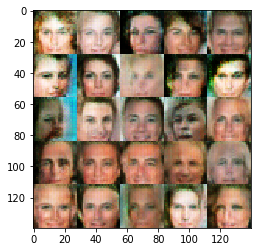

Epoch 1/3... Discriminator Loss: 1.3285... Generator Loss: 0.8150
Epoch 1/3... Discriminator Loss: 1.5759... Generator Loss: 0.3858
Epoch 1/3... Discriminator Loss: 1.1714... Generator Loss: 1.0403
Epoch 1/3... Discriminator Loss: 1.7385... Generator Loss: 0.3209
Epoch 1/3... Discriminator Loss: 1.2318... Generator Loss: 0.9057
Epoch 1/3... Discriminator Loss: 1.3062... Generator Loss: 1.0284
Epoch 1/3... Discriminator Loss: 1.5270... Generator Loss: 0.4430
Epoch 1/3... Discriminator Loss: 1.4744... Generator Loss: 0.4632
Epoch 1/3... Discriminator Loss: 1.5499... Generator Loss: 0.4192
Epoch 1/3... Discriminator Loss: 1.3967... Generator Loss: 0.5081
Epoch 1/3... Discriminator Loss: 1.2667... Generator Loss: 0.7204
Epoch 1/3... Discriminator Loss: 1.6663... Generator Loss: 0.3531
Epoch 1/3... Discriminator Loss: 1.2180... Generator Loss: 0.7247
Epoch 1/3... Discriminator Loss: 1.1194... Generator Loss: 0.8831
Epoch 1/3... Discriminator Loss: 1.2865... Generator Loss: 0.7534
Epoch 1/3.

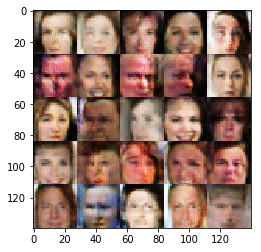

Epoch 1/3... Discriminator Loss: 1.3479... Generator Loss: 0.5373
Epoch 1/3... Discriminator Loss: 1.1840... Generator Loss: 1.2228
Epoch 1/3... Discriminator Loss: 1.3134... Generator Loss: 0.7273
Epoch 1/3... Discriminator Loss: 1.2493... Generator Loss: 0.6291
Epoch 1/3... Discriminator Loss: 1.1595... Generator Loss: 0.7533
Epoch 1/3... Discriminator Loss: 1.1822... Generator Loss: 0.7715
Epoch 1/3... Discriminator Loss: 1.5500... Generator Loss: 0.3862
Epoch 1/3... Discriminator Loss: 1.1023... Generator Loss: 0.7625
Epoch 1/3... Discriminator Loss: 1.2300... Generator Loss: 0.6728
Epoch 1/3... Discriminator Loss: 1.4314... Generator Loss: 0.4709
Epoch 1/3... Discriminator Loss: 1.2181... Generator Loss: 0.8770
Epoch 1/3... Discriminator Loss: 1.3125... Generator Loss: 0.6249
Epoch 1/3... Discriminator Loss: 1.2141... Generator Loss: 0.7677
Epoch 1/3... Discriminator Loss: 1.1724... Generator Loss: 0.9165
Epoch 1/3... Discriminator Loss: 1.4170... Generator Loss: 0.5406
Epoch 1/3.

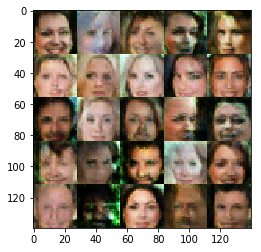

Epoch 1/3... Discriminator Loss: 1.2214... Generator Loss: 0.7999
Epoch 1/3... Discriminator Loss: 1.1321... Generator Loss: 0.8449
Epoch 1/3... Discriminator Loss: 1.2525... Generator Loss: 1.0249
Epoch 1/3... Discriminator Loss: 1.5165... Generator Loss: 0.4046
Epoch 1/3... Discriminator Loss: 1.2316... Generator Loss: 0.8955
Epoch 1/3... Discriminator Loss: 1.0503... Generator Loss: 1.0640
Epoch 1/3... Discriminator Loss: 1.5600... Generator Loss: 0.4019
Epoch 1/3... Discriminator Loss: 1.1096... Generator Loss: 0.8111
Epoch 1/3... Discriminator Loss: 1.3817... Generator Loss: 0.6070
Epoch 1/3... Discriminator Loss: 1.2208... Generator Loss: 0.6868
Epoch 1/3... Discriminator Loss: 1.3558... Generator Loss: 0.5353
Epoch 1/3... Discriminator Loss: 1.3041... Generator Loss: 0.5441
Epoch 1/3... Discriminator Loss: 1.2054... Generator Loss: 0.6955
Epoch 1/3... Discriminator Loss: 1.1235... Generator Loss: 0.8301
Epoch 1/3... Discriminator Loss: 1.2468... Generator Loss: 0.7466
Epoch 1/3.

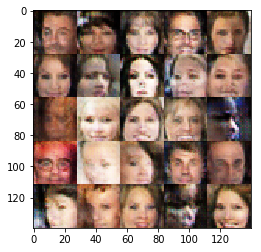

Epoch 2/3... Discriminator Loss: 1.4880... Generator Loss: 0.4241
Epoch 2/3... Discriminator Loss: 1.5145... Generator Loss: 0.4378
Epoch 2/3... Discriminator Loss: 1.5854... Generator Loss: 0.4098
Epoch 2/3... Discriminator Loss: 1.3667... Generator Loss: 0.9824
Epoch 2/3... Discriminator Loss: 1.3120... Generator Loss: 0.6230
Epoch 2/3... Discriminator Loss: 1.4808... Generator Loss: 0.4513
Epoch 2/3... Discriminator Loss: 1.1702... Generator Loss: 0.9164
Epoch 2/3... Discriminator Loss: 1.2260... Generator Loss: 1.3333
Epoch 2/3... Discriminator Loss: 1.1308... Generator Loss: 0.9168
Epoch 2/3... Discriminator Loss: 1.5803... Generator Loss: 0.4012
Epoch 2/3... Discriminator Loss: 1.4029... Generator Loss: 0.5632
Epoch 2/3... Discriminator Loss: 1.2475... Generator Loss: 0.9964
Epoch 2/3... Discriminator Loss: 1.3225... Generator Loss: 0.5416
Epoch 2/3... Discriminator Loss: 1.3719... Generator Loss: 0.5273
Epoch 2/3... Discriminator Loss: 1.0890... Generator Loss: 0.8283
Epoch 2/3.

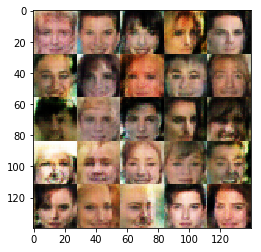

Epoch 2/3... Discriminator Loss: 1.4139... Generator Loss: 0.4698
Epoch 2/3... Discriminator Loss: 1.1100... Generator Loss: 0.8837
Epoch 2/3... Discriminator Loss: 1.0411... Generator Loss: 1.0417
Epoch 2/3... Discriminator Loss: 1.2641... Generator Loss: 0.6957
Epoch 2/3... Discriminator Loss: 1.1342... Generator Loss: 0.8783
Epoch 2/3... Discriminator Loss: 1.3017... Generator Loss: 0.6272
Epoch 2/3... Discriminator Loss: 1.3735... Generator Loss: 0.5632
Epoch 2/3... Discriminator Loss: 1.2791... Generator Loss: 0.7596
Epoch 2/3... Discriminator Loss: 1.1980... Generator Loss: 1.0773
Epoch 2/3... Discriminator Loss: 1.1157... Generator Loss: 0.7519
Epoch 2/3... Discriminator Loss: 1.1799... Generator Loss: 1.4499
Epoch 2/3... Discriminator Loss: 1.1252... Generator Loss: 0.8002
Epoch 2/3... Discriminator Loss: 1.5097... Generator Loss: 0.4732
Epoch 2/3... Discriminator Loss: 1.2026... Generator Loss: 0.8675
Epoch 2/3... Discriminator Loss: 1.1107... Generator Loss: 0.8706
Epoch 2/3.

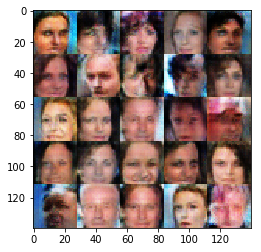

Epoch 2/3... Discriminator Loss: 1.1098... Generator Loss: 0.7528
Epoch 2/3... Discriminator Loss: 1.0587... Generator Loss: 1.0437
Epoch 2/3... Discriminator Loss: 1.3069... Generator Loss: 0.6667
Epoch 2/3... Discriminator Loss: 1.3344... Generator Loss: 0.5345
Epoch 2/3... Discriminator Loss: 1.4466... Generator Loss: 0.5025
Epoch 2/3... Discriminator Loss: 1.3717... Generator Loss: 0.5089
Epoch 2/3... Discriminator Loss: 1.4490... Generator Loss: 0.4660
Epoch 2/3... Discriminator Loss: 1.2635... Generator Loss: 0.5770
Epoch 2/3... Discriminator Loss: 1.4000... Generator Loss: 0.5260
Epoch 2/3... Discriminator Loss: 1.1393... Generator Loss: 0.7872
Epoch 2/3... Discriminator Loss: 1.6547... Generator Loss: 0.3742
Epoch 2/3... Discriminator Loss: 1.2766... Generator Loss: 0.6249
Epoch 2/3... Discriminator Loss: 1.4094... Generator Loss: 0.5273
Epoch 2/3... Discriminator Loss: 1.1456... Generator Loss: 0.8120
Epoch 2/3... Discriminator Loss: 1.6227... Generator Loss: 0.4384
Epoch 2/3.

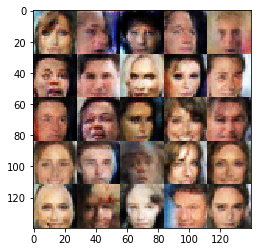

Epoch 2/3... Discriminator Loss: 1.1904... Generator Loss: 0.8968
Epoch 2/3... Discriminator Loss: 1.9262... Generator Loss: 0.2781
Epoch 2/3... Discriminator Loss: 1.0040... Generator Loss: 1.2988
Epoch 2/3... Discriminator Loss: 1.2572... Generator Loss: 0.7082
Epoch 2/3... Discriminator Loss: 1.1137... Generator Loss: 0.9339
Epoch 2/3... Discriminator Loss: 1.4500... Generator Loss: 0.5541
Epoch 2/3... Discriminator Loss: 1.1650... Generator Loss: 0.9307
Epoch 2/3... Discriminator Loss: 1.8119... Generator Loss: 0.2973
Epoch 2/3... Discriminator Loss: 1.3472... Generator Loss: 0.6411
Epoch 2/3... Discriminator Loss: 1.5737... Generator Loss: 0.4370
Epoch 2/3... Discriminator Loss: 1.1251... Generator Loss: 0.7481
Epoch 2/3... Discriminator Loss: 1.8264... Generator Loss: 0.3017
Epoch 2/3... Discriminator Loss: 1.2292... Generator Loss: 0.7822
Epoch 2/3... Discriminator Loss: 1.1300... Generator Loss: 0.8622
Epoch 2/3... Discriminator Loss: 1.2534... Generator Loss: 0.8085
Epoch 2/3.

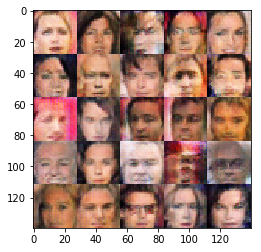

Epoch 2/3... Discriminator Loss: 1.1848... Generator Loss: 0.7687
Epoch 2/3... Discriminator Loss: 1.3266... Generator Loss: 0.6771
Epoch 2/3... Discriminator Loss: 1.0829... Generator Loss: 1.1232
Epoch 2/3... Discriminator Loss: 1.6465... Generator Loss: 0.3594
Epoch 2/3... Discriminator Loss: 1.8837... Generator Loss: 0.2698
Epoch 2/3... Discriminator Loss: 1.1419... Generator Loss: 0.8550
Epoch 2/3... Discriminator Loss: 1.2759... Generator Loss: 0.6689
Epoch 2/3... Discriminator Loss: 1.4690... Generator Loss: 0.4746
Epoch 2/3... Discriminator Loss: 1.3172... Generator Loss: 0.5574
Epoch 2/3... Discriminator Loss: 1.1938... Generator Loss: 0.7507
Epoch 2/3... Discriminator Loss: 1.4736... Generator Loss: 0.4320
Epoch 2/3... Discriminator Loss: 1.3303... Generator Loss: 0.6032
Epoch 2/3... Discriminator Loss: 1.2726... Generator Loss: 0.6251
Epoch 2/3... Discriminator Loss: 1.1533... Generator Loss: 0.8460
Epoch 2/3... Discriminator Loss: 1.2965... Generator Loss: 0.5474
Epoch 2/3.

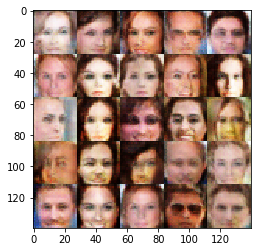

Epoch 2/3... Discriminator Loss: 1.6424... Generator Loss: 0.3585
Epoch 2/3... Discriminator Loss: 1.1275... Generator Loss: 0.8647
Epoch 2/3... Discriminator Loss: 1.7030... Generator Loss: 0.3167
Epoch 2/3... Discriminator Loss: 1.1870... Generator Loss: 0.7556
Epoch 2/3... Discriminator Loss: 1.4811... Generator Loss: 0.5348
Epoch 2/3... Discriminator Loss: 1.8065... Generator Loss: 0.2841
Epoch 2/3... Discriminator Loss: 1.3246... Generator Loss: 0.5363
Epoch 2/3... Discriminator Loss: 1.3549... Generator Loss: 0.5833
Epoch 2/3... Discriminator Loss: 1.3847... Generator Loss: 0.6359
Epoch 2/3... Discriminator Loss: 1.7379... Generator Loss: 0.3125
Epoch 2/3... Discriminator Loss: 1.4619... Generator Loss: 0.4765
Epoch 2/3... Discriminator Loss: 1.4005... Generator Loss: 0.4915
Epoch 2/3... Discriminator Loss: 1.4930... Generator Loss: 0.4224
Epoch 2/3... Discriminator Loss: 1.2569... Generator Loss: 0.8174
Epoch 2/3... Discriminator Loss: 1.4527... Generator Loss: 0.4657
Epoch 2/3.

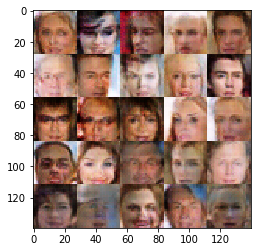

Epoch 2/3... Discriminator Loss: 1.4529... Generator Loss: 0.4411
Epoch 2/3... Discriminator Loss: 1.0148... Generator Loss: 0.8873
Epoch 2/3... Discriminator Loss: 1.2187... Generator Loss: 0.6512
Epoch 2/3... Discriminator Loss: 1.4111... Generator Loss: 0.5397
Epoch 2/3... Discriminator Loss: 1.2061... Generator Loss: 0.6551
Epoch 2/3... Discriminator Loss: 1.5674... Generator Loss: 0.3868
Epoch 2/3... Discriminator Loss: 1.2881... Generator Loss: 0.8186
Epoch 2/3... Discriminator Loss: 1.1983... Generator Loss: 0.7092
Epoch 2/3... Discriminator Loss: 1.6661... Generator Loss: 0.3340
Epoch 2/3... Discriminator Loss: 1.3762... Generator Loss: 0.6027
Epoch 2/3... Discriminator Loss: 1.5247... Generator Loss: 0.4044
Epoch 2/3... Discriminator Loss: 1.1004... Generator Loss: 0.9296
Epoch 2/3... Discriminator Loss: 1.3662... Generator Loss: 0.8094
Epoch 2/3... Discriminator Loss: 1.2337... Generator Loss: 0.6120
Epoch 2/3... Discriminator Loss: 1.6005... Generator Loss: 0.4027
Epoch 2/3.

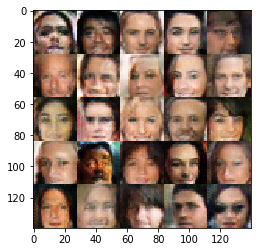

Epoch 2/3... Discriminator Loss: 1.4397... Generator Loss: 0.5146
Epoch 2/3... Discriminator Loss: 1.5293... Generator Loss: 0.4209
Epoch 2/3... Discriminator Loss: 1.1899... Generator Loss: 0.7083
Epoch 2/3... Discriminator Loss: 1.1984... Generator Loss: 0.6340
Epoch 2/3... Discriminator Loss: 1.3181... Generator Loss: 0.5384
Epoch 2/3... Discriminator Loss: 1.3183... Generator Loss: 0.5619
Epoch 2/3... Discriminator Loss: 1.3277... Generator Loss: 0.6030
Epoch 2/3... Discriminator Loss: 1.2181... Generator Loss: 1.1970
Epoch 2/3... Discriminator Loss: 1.2502... Generator Loss: 1.0042
Epoch 2/3... Discriminator Loss: 1.4790... Generator Loss: 0.4552
Epoch 2/3... Discriminator Loss: 1.7768... Generator Loss: 0.2989
Epoch 2/3... Discriminator Loss: 1.1865... Generator Loss: 0.7191
Epoch 2/3... Discriminator Loss: 1.6405... Generator Loss: 0.3562
Epoch 2/3... Discriminator Loss: 1.3667... Generator Loss: 0.5321
Epoch 2/3... Discriminator Loss: 1.5527... Generator Loss: 0.4149
Epoch 2/3.

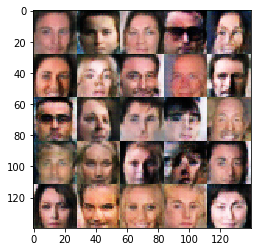

Epoch 2/3... Discriminator Loss: 1.1474... Generator Loss: 0.7851
Epoch 2/3... Discriminator Loss: 1.3546... Generator Loss: 0.9122
Epoch 2/3... Discriminator Loss: 1.3998... Generator Loss: 0.4905
Epoch 2/3... Discriminator Loss: 1.6171... Generator Loss: 0.3607
Epoch 2/3... Discriminator Loss: 1.3012... Generator Loss: 0.6787
Epoch 2/3... Discriminator Loss: 1.2754... Generator Loss: 0.6040
Epoch 2/3... Discriminator Loss: 1.3618... Generator Loss: 0.5169
Epoch 2/3... Discriminator Loss: 1.4434... Generator Loss: 0.4699
Epoch 2/3... Discriminator Loss: 1.4808... Generator Loss: 0.4518
Epoch 2/3... Discriminator Loss: 1.2900... Generator Loss: 0.6173
Epoch 2/3... Discriminator Loss: 1.4503... Generator Loss: 0.5983
Epoch 2/3... Discriminator Loss: 1.2575... Generator Loss: 1.3180
Epoch 2/3... Discriminator Loss: 1.1980... Generator Loss: 0.7388
Epoch 2/3... Discriminator Loss: 1.3336... Generator Loss: 0.5355
Epoch 2/3... Discriminator Loss: 1.2421... Generator Loss: 0.6322
Epoch 2/3.

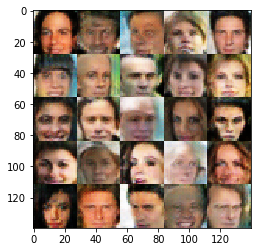

Epoch 2/3... Discriminator Loss: 1.6668... Generator Loss: 0.3714
Epoch 2/3... Discriminator Loss: 1.2166... Generator Loss: 0.6297
Epoch 2/3... Discriminator Loss: 1.3389... Generator Loss: 0.5367
Epoch 2/3... Discriminator Loss: 1.2532... Generator Loss: 0.6653
Epoch 2/3... Discriminator Loss: 1.2794... Generator Loss: 0.6537
Epoch 2/3... Discriminator Loss: 1.3694... Generator Loss: 0.5465
Epoch 2/3... Discriminator Loss: 1.4348... Generator Loss: 0.5051
Epoch 2/3... Discriminator Loss: 1.4227... Generator Loss: 0.5578
Epoch 2/3... Discriminator Loss: 1.2527... Generator Loss: 0.6082
Epoch 2/3... Discriminator Loss: 1.2600... Generator Loss: 0.6979
Epoch 2/3... Discriminator Loss: 1.3174... Generator Loss: 0.5497
Epoch 2/3... Discriminator Loss: 1.4204... Generator Loss: 0.4765
Epoch 2/3... Discriminator Loss: 1.2956... Generator Loss: 0.5746
Epoch 2/3... Discriminator Loss: 1.5478... Generator Loss: 0.4861
Epoch 2/3... Discriminator Loss: 1.2027... Generator Loss: 1.5225
Epoch 2/3.

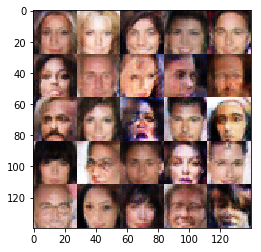

Epoch 2/3... Discriminator Loss: 1.6824... Generator Loss: 0.3313
Epoch 2/3... Discriminator Loss: 1.3171... Generator Loss: 0.5539
Epoch 2/3... Discriminator Loss: 1.4442... Generator Loss: 0.4897
Epoch 2/3... Discriminator Loss: 1.3142... Generator Loss: 0.5884
Epoch 2/3... Discriminator Loss: 1.1229... Generator Loss: 1.0326
Epoch 2/3... Discriminator Loss: 1.3323... Generator Loss: 0.6591
Epoch 2/3... Discriminator Loss: 1.1061... Generator Loss: 0.7773
Epoch 2/3... Discriminator Loss: 1.1864... Generator Loss: 0.8202
Epoch 2/3... Discriminator Loss: 1.4278... Generator Loss: 0.4810
Epoch 2/3... Discriminator Loss: 1.2620... Generator Loss: 0.6679
Epoch 2/3... Discriminator Loss: 1.1484... Generator Loss: 0.9595
Epoch 2/3... Discriminator Loss: 1.2505... Generator Loss: 0.7467
Epoch 2/3... Discriminator Loss: 1.2999... Generator Loss: 0.5741
Epoch 2/3... Discriminator Loss: 1.0114... Generator Loss: 0.9618
Epoch 2/3... Discriminator Loss: 1.2841... Generator Loss: 0.5839
Epoch 2/3.

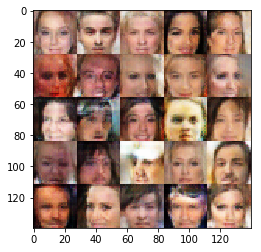

Epoch 2/3... Discriminator Loss: 1.3553... Generator Loss: 0.5463
Epoch 2/3... Discriminator Loss: 1.2585... Generator Loss: 0.5935
Epoch 2/3... Discriminator Loss: 1.2063... Generator Loss: 0.8647
Epoch 2/3... Discriminator Loss: 1.8110... Generator Loss: 0.2946
Epoch 2/3... Discriminator Loss: 1.2849... Generator Loss: 0.7287
Epoch 2/3... Discriminator Loss: 1.1521... Generator Loss: 0.8424
Epoch 2/3... Discriminator Loss: 1.2567... Generator Loss: 0.8408
Epoch 2/3... Discriminator Loss: 1.6477... Generator Loss: 0.3841
Epoch 2/3... Discriminator Loss: 1.1752... Generator Loss: 0.8354
Epoch 2/3... Discriminator Loss: 1.4838... Generator Loss: 0.4519
Epoch 2/3... Discriminator Loss: 1.2416... Generator Loss: 0.6360
Epoch 2/3... Discriminator Loss: 1.3696... Generator Loss: 0.5364
Epoch 2/3... Discriminator Loss: 1.3200... Generator Loss: 0.5871
Epoch 2/3... Discriminator Loss: 1.3978... Generator Loss: 0.5043
Epoch 2/3... Discriminator Loss: 1.2624... Generator Loss: 1.0540
Epoch 2/3.

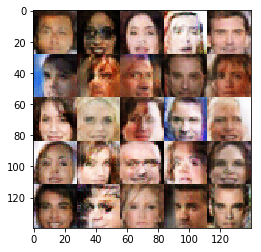

Epoch 2/3... Discriminator Loss: 1.0644... Generator Loss: 1.0124
Epoch 2/3... Discriminator Loss: 1.2742... Generator Loss: 0.8982
Epoch 2/3... Discriminator Loss: 1.0505... Generator Loss: 0.8129
Epoch 2/3... Discriminator Loss: 1.6918... Generator Loss: 0.4488
Epoch 2/3... Discriminator Loss: 1.3333... Generator Loss: 0.5756
Epoch 2/3... Discriminator Loss: 1.2142... Generator Loss: 0.6276
Epoch 2/3... Discriminator Loss: 1.5749... Generator Loss: 0.4892
Epoch 2/3... Discriminator Loss: 1.0735... Generator Loss: 0.8578
Epoch 2/3... Discriminator Loss: 1.4299... Generator Loss: 0.4621
Epoch 2/3... Discriminator Loss: 1.2782... Generator Loss: 0.5925
Epoch 2/3... Discriminator Loss: 1.5377... Generator Loss: 0.4032
Epoch 2/3... Discriminator Loss: 1.3312... Generator Loss: 0.5145
Epoch 2/3... Discriminator Loss: 1.8820... Generator Loss: 0.2741
Epoch 2/3... Discriminator Loss: 1.3280... Generator Loss: 0.5231
Epoch 2/3... Discriminator Loss: 1.5384... Generator Loss: 0.5028
Epoch 2/3.

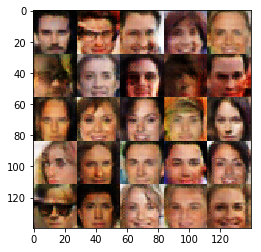

Epoch 2/3... Discriminator Loss: 1.1355... Generator Loss: 0.9012
Epoch 2/3... Discriminator Loss: 1.6079... Generator Loss: 0.4117
Epoch 2/3... Discriminator Loss: 1.2141... Generator Loss: 0.6572
Epoch 2/3... Discriminator Loss: 1.0179... Generator Loss: 0.8703
Epoch 2/3... Discriminator Loss: 1.3923... Generator Loss: 0.5431
Epoch 2/3... Discriminator Loss: 1.8260... Generator Loss: 0.2959
Epoch 2/3... Discriminator Loss: 1.2570... Generator Loss: 0.8602
Epoch 2/3... Discriminator Loss: 1.3549... Generator Loss: 0.5794
Epoch 2/3... Discriminator Loss: 1.4710... Generator Loss: 0.4550
Epoch 2/3... Discriminator Loss: 1.2402... Generator Loss: 1.2005
Epoch 2/3... Discriminator Loss: 1.1717... Generator Loss: 0.7865
Epoch 2/3... Discriminator Loss: 1.2465... Generator Loss: 0.6572
Epoch 2/3... Discriminator Loss: 1.7792... Generator Loss: 0.3144
Epoch 2/3... Discriminator Loss: 1.2841... Generator Loss: 0.7887
Epoch 2/3... Discriminator Loss: 1.3713... Generator Loss: 0.5130
Epoch 2/3.

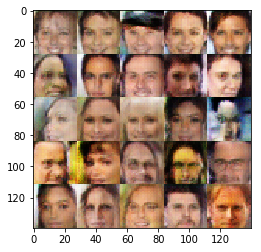

Epoch 2/3... Discriminator Loss: 1.4105... Generator Loss: 0.5334
Epoch 2/3... Discriminator Loss: 1.0922... Generator Loss: 0.8509
Epoch 2/3... Discriminator Loss: 1.3748... Generator Loss: 0.5850
Epoch 2/3... Discriminator Loss: 1.2360... Generator Loss: 0.6913
Epoch 2/3... Discriminator Loss: 1.5096... Generator Loss: 0.5132
Epoch 2/3... Discriminator Loss: 1.3383... Generator Loss: 0.7961
Epoch 2/3... Discriminator Loss: 1.1901... Generator Loss: 0.8965
Epoch 2/3... Discriminator Loss: 1.2778... Generator Loss: 0.6415
Epoch 2/3... Discriminator Loss: 1.2955... Generator Loss: 0.6099
Epoch 2/3... Discriminator Loss: 1.1838... Generator Loss: 0.7339
Epoch 2/3... Discriminator Loss: 1.4900... Generator Loss: 0.4400
Epoch 2/3... Discriminator Loss: 1.2393... Generator Loss: 0.6536
Epoch 2/3... Discriminator Loss: 1.3761... Generator Loss: 0.5713
Epoch 2/3... Discriminator Loss: 1.6112... Generator Loss: 0.3730
Epoch 2/3... Discriminator Loss: 1.3334... Generator Loss: 0.5003
Epoch 2/3.

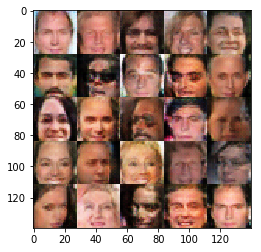

Epoch 2/3... Discriminator Loss: 1.5685... Generator Loss: 0.3887
Epoch 2/3... Discriminator Loss: 1.3610... Generator Loss: 0.5793
Epoch 2/3... Discriminator Loss: 1.2574... Generator Loss: 0.6922
Epoch 2/3... Discriminator Loss: 1.1992... Generator Loss: 0.6332
Epoch 2/3... Discriminator Loss: 1.3054... Generator Loss: 0.7308
Epoch 2/3... Discriminator Loss: 1.5210... Generator Loss: 0.6066
Epoch 2/3... Discriminator Loss: 1.2253... Generator Loss: 0.9451
Epoch 2/3... Discriminator Loss: 1.4530... Generator Loss: 0.4851
Epoch 2/3... Discriminator Loss: 1.2267... Generator Loss: 0.8085
Epoch 2/3... Discriminator Loss: 1.3813... Generator Loss: 0.5225
Epoch 2/3... Discriminator Loss: 1.1514... Generator Loss: 0.9398
Epoch 2/3... Discriminator Loss: 1.1185... Generator Loss: 0.7504
Epoch 2/3... Discriminator Loss: 1.0725... Generator Loss: 0.8540
Epoch 3/3... Discriminator Loss: 1.1869... Generator Loss: 0.6960
Epoch 3/3... Discriminator Loss: 1.5823... Generator Loss: 0.4495
Epoch 3/3.

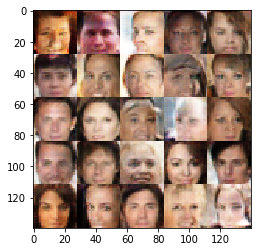

Epoch 3/3... Discriminator Loss: 1.6101... Generator Loss: 0.3779
Epoch 3/3... Discriminator Loss: 1.2479... Generator Loss: 1.1846
Epoch 3/3... Discriminator Loss: 1.2257... Generator Loss: 0.9282
Epoch 3/3... Discriminator Loss: 1.4542... Generator Loss: 0.4446
Epoch 3/3... Discriminator Loss: 1.2983... Generator Loss: 0.6022
Epoch 3/3... Discriminator Loss: 1.5582... Generator Loss: 0.4140
Epoch 3/3... Discriminator Loss: 1.3158... Generator Loss: 0.8063
Epoch 3/3... Discriminator Loss: 1.5161... Generator Loss: 0.4192
Epoch 3/3... Discriminator Loss: 1.3889... Generator Loss: 0.4884
Epoch 3/3... Discriminator Loss: 1.1398... Generator Loss: 0.7896
Epoch 3/3... Discriminator Loss: 1.2980... Generator Loss: 0.8657
Epoch 3/3... Discriminator Loss: 1.2158... Generator Loss: 0.6283
Epoch 3/3... Discriminator Loss: 1.2007... Generator Loss: 0.8048
Epoch 3/3... Discriminator Loss: 1.3661... Generator Loss: 0.6005
Epoch 3/3... Discriminator Loss: 1.3637... Generator Loss: 0.5241
Epoch 3/3.

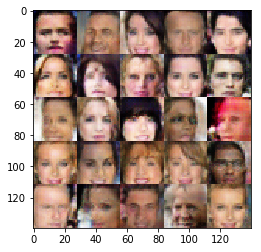

Epoch 3/3... Discriminator Loss: 1.4201... Generator Loss: 0.5755
Epoch 3/3... Discriminator Loss: 1.2714... Generator Loss: 0.6512
Epoch 3/3... Discriminator Loss: 1.2094... Generator Loss: 0.6562
Epoch 3/3... Discriminator Loss: 1.3744... Generator Loss: 0.5283
Epoch 3/3... Discriminator Loss: 1.1537... Generator Loss: 0.7216
Epoch 3/3... Discriminator Loss: 1.4489... Generator Loss: 0.5024
Epoch 3/3... Discriminator Loss: 1.1553... Generator Loss: 0.7681
Epoch 3/3... Discriminator Loss: 1.4256... Generator Loss: 0.4687
Epoch 3/3... Discriminator Loss: 1.3787... Generator Loss: 0.4843
Epoch 3/3... Discriminator Loss: 0.9755... Generator Loss: 0.9474
Epoch 3/3... Discriminator Loss: 1.2817... Generator Loss: 0.7553
Epoch 3/3... Discriminator Loss: 1.3330... Generator Loss: 0.5553
Epoch 3/3... Discriminator Loss: 1.3006... Generator Loss: 0.5822
Epoch 3/3... Discriminator Loss: 1.9822... Generator Loss: 0.2580
Epoch 3/3... Discriminator Loss: 1.2108... Generator Loss: 0.6503
Epoch 3/3.

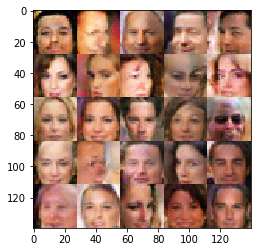

Epoch 3/3... Discriminator Loss: 0.9730... Generator Loss: 1.1921
Epoch 3/3... Discriminator Loss: 1.3517... Generator Loss: 1.1771
Epoch 3/3... Discriminator Loss: 1.4751... Generator Loss: 0.4598
Epoch 3/3... Discriminator Loss: 1.2669... Generator Loss: 0.5769
Epoch 3/3... Discriminator Loss: 1.2485... Generator Loss: 0.9027
Epoch 3/3... Discriminator Loss: 1.3016... Generator Loss: 0.5539
Epoch 3/3... Discriminator Loss: 1.2114... Generator Loss: 0.7237
Epoch 3/3... Discriminator Loss: 1.2899... Generator Loss: 0.6714
Epoch 3/3... Discriminator Loss: 1.4836... Generator Loss: 0.4792
Epoch 3/3... Discriminator Loss: 1.2486... Generator Loss: 0.9275
Epoch 3/3... Discriminator Loss: 1.2477... Generator Loss: 0.6836
Epoch 3/3... Discriminator Loss: 1.0322... Generator Loss: 0.8828
Epoch 3/3... Discriminator Loss: 1.1570... Generator Loss: 0.6514
Epoch 3/3... Discriminator Loss: 1.1122... Generator Loss: 0.6987
Epoch 3/3... Discriminator Loss: 1.2234... Generator Loss: 0.6728
Epoch 3/3.

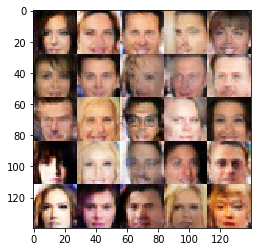

Epoch 3/3... Discriminator Loss: 1.2654... Generator Loss: 0.7341
Epoch 3/3... Discriminator Loss: 1.6154... Generator Loss: 0.3800
Epoch 3/3... Discriminator Loss: 1.4117... Generator Loss: 0.5060
Epoch 3/3... Discriminator Loss: 1.1509... Generator Loss: 0.8261
Epoch 3/3... Discriminator Loss: 1.1545... Generator Loss: 1.1255
Epoch 3/3... Discriminator Loss: 1.3869... Generator Loss: 0.5539
Epoch 3/3... Discriminator Loss: 1.2172... Generator Loss: 0.8655
Epoch 3/3... Discriminator Loss: 1.5063... Generator Loss: 0.5350
Epoch 3/3... Discriminator Loss: 1.3199... Generator Loss: 0.5924
Epoch 3/3... Discriminator Loss: 1.0845... Generator Loss: 0.8081
Epoch 3/3... Discriminator Loss: 1.2614... Generator Loss: 0.6704
Epoch 3/3... Discriminator Loss: 1.2082... Generator Loss: 0.8153
Epoch 3/3... Discriminator Loss: 1.1488... Generator Loss: 0.9011
Epoch 3/3... Discriminator Loss: 1.0976... Generator Loss: 0.8190
Epoch 3/3... Discriminator Loss: 1.7484... Generator Loss: 0.3253
Epoch 3/3.

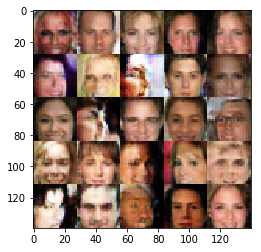

Epoch 3/3... Discriminator Loss: 1.5079... Generator Loss: 0.4837
Epoch 3/3... Discriminator Loss: 1.1638... Generator Loss: 0.7245
Epoch 3/3... Discriminator Loss: 1.0345... Generator Loss: 0.8979
Epoch 3/3... Discriminator Loss: 1.4367... Generator Loss: 0.4660
Epoch 3/3... Discriminator Loss: 1.3634... Generator Loss: 0.5587
Epoch 3/3... Discriminator Loss: 1.2633... Generator Loss: 0.7096
Epoch 3/3... Discriminator Loss: 1.2661... Generator Loss: 0.6005
Epoch 3/3... Discriminator Loss: 1.2658... Generator Loss: 0.6068
Epoch 3/3... Discriminator Loss: 1.1502... Generator Loss: 1.4087
Epoch 3/3... Discriminator Loss: 1.2224... Generator Loss: 0.6004
Epoch 3/3... Discriminator Loss: 1.3907... Generator Loss: 1.0340
Epoch 3/3... Discriminator Loss: 1.3696... Generator Loss: 0.5201
Epoch 3/3... Discriminator Loss: 1.0765... Generator Loss: 0.8701
Epoch 3/3... Discriminator Loss: 1.5415... Generator Loss: 0.4571
Epoch 3/3... Discriminator Loss: 1.4560... Generator Loss: 0.4979
Epoch 3/3.

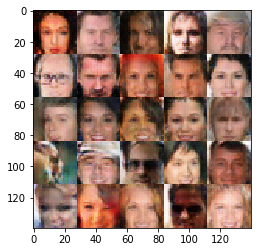

Epoch 3/3... Discriminator Loss: 1.1982... Generator Loss: 0.6387
Epoch 3/3... Discriminator Loss: 1.6998... Generator Loss: 0.3654
Epoch 3/3... Discriminator Loss: 1.2430... Generator Loss: 0.6260
Epoch 3/3... Discriminator Loss: 1.3669... Generator Loss: 0.7495
Epoch 3/3... Discriminator Loss: 1.4338... Generator Loss: 0.4863
Epoch 3/3... Discriminator Loss: 1.3007... Generator Loss: 0.5530
Epoch 3/3... Discriminator Loss: 1.4466... Generator Loss: 0.4586
Epoch 3/3... Discriminator Loss: 1.3930... Generator Loss: 0.4818
Epoch 3/3... Discriminator Loss: 1.5534... Generator Loss: 0.4269
Epoch 3/3... Discriminator Loss: 1.4496... Generator Loss: 0.4881
Epoch 3/3... Discriminator Loss: 1.8591... Generator Loss: 0.2750
Epoch 3/3... Discriminator Loss: 1.2204... Generator Loss: 0.6581
Epoch 3/3... Discriminator Loss: 1.2061... Generator Loss: 0.7073
Epoch 3/3... Discriminator Loss: 1.1300... Generator Loss: 0.7444
Epoch 3/3... Discriminator Loss: 1.2923... Generator Loss: 1.2483
Epoch 3/3.

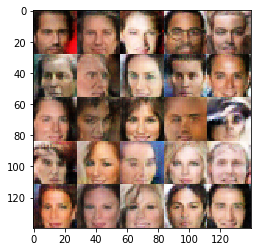

Epoch 3/3... Discriminator Loss: 1.1528... Generator Loss: 0.9537
Epoch 3/3... Discriminator Loss: 1.1966... Generator Loss: 0.8676
Epoch 3/3... Discriminator Loss: 1.3169... Generator Loss: 0.6085
Epoch 3/3... Discriminator Loss: 1.2339... Generator Loss: 0.9073
Epoch 3/3... Discriminator Loss: 1.4535... Generator Loss: 0.4785
Epoch 3/3... Discriminator Loss: 1.1095... Generator Loss: 0.9128
Epoch 3/3... Discriminator Loss: 1.3155... Generator Loss: 0.6634
Epoch 3/3... Discriminator Loss: 1.1478... Generator Loss: 0.7624
Epoch 3/3... Discriminator Loss: 1.1366... Generator Loss: 0.7594
Epoch 3/3... Discriminator Loss: 1.4961... Generator Loss: 0.4457
Epoch 3/3... Discriminator Loss: 1.4025... Generator Loss: 0.5391
Epoch 3/3... Discriminator Loss: 1.1504... Generator Loss: 0.6898
Epoch 3/3... Discriminator Loss: 1.2963... Generator Loss: 0.5904
Epoch 3/3... Discriminator Loss: 1.3392... Generator Loss: 0.5177
Epoch 3/3... Discriminator Loss: 1.4447... Generator Loss: 0.4598
Epoch 3/3.

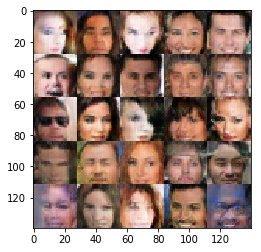

Epoch 3/3... Discriminator Loss: 1.3458... Generator Loss: 0.5077
Epoch 3/3... Discriminator Loss: 1.1968... Generator Loss: 0.6575
Epoch 3/3... Discriminator Loss: 1.3893... Generator Loss: 0.4811
Epoch 3/3... Discriminator Loss: 1.4059... Generator Loss: 0.4955
Epoch 3/3... Discriminator Loss: 1.4799... Generator Loss: 0.4636
Epoch 3/3... Discriminator Loss: 1.5688... Generator Loss: 0.3732
Epoch 3/3... Discriminator Loss: 1.7368... Generator Loss: 0.3372
Epoch 3/3... Discriminator Loss: 1.2462... Generator Loss: 0.6553
Epoch 3/3... Discriminator Loss: 1.4038... Generator Loss: 0.5983
Epoch 3/3... Discriminator Loss: 1.2427... Generator Loss: 0.7107
Epoch 3/3... Discriminator Loss: 1.3450... Generator Loss: 0.5052
Epoch 3/3... Discriminator Loss: 1.2004... Generator Loss: 0.6791
Epoch 3/3... Discriminator Loss: 1.1178... Generator Loss: 0.8530
Epoch 3/3... Discriminator Loss: 1.4048... Generator Loss: 0.5110
Epoch 3/3... Discriminator Loss: 1.4038... Generator Loss: 0.4762
Epoch 3/3.

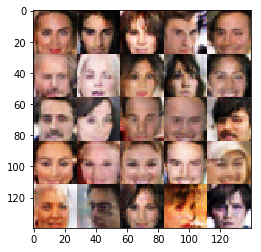

Epoch 3/3... Discriminator Loss: 1.2323... Generator Loss: 0.6336
Epoch 3/3... Discriminator Loss: 1.9090... Generator Loss: 0.2547
Epoch 3/3... Discriminator Loss: 1.4479... Generator Loss: 0.4739
Epoch 3/3... Discriminator Loss: 1.4755... Generator Loss: 0.4515
Epoch 3/3... Discriminator Loss: 1.4698... Generator Loss: 0.4909
Epoch 3/3... Discriminator Loss: 1.2418... Generator Loss: 0.7262
Epoch 3/3... Discriminator Loss: 1.3593... Generator Loss: 0.6062
Epoch 3/3... Discriminator Loss: 1.1742... Generator Loss: 0.6316
Epoch 3/3... Discriminator Loss: 1.2984... Generator Loss: 0.6835
Epoch 3/3... Discriminator Loss: 1.2754... Generator Loss: 0.6763
Epoch 3/3... Discriminator Loss: 1.4641... Generator Loss: 0.4215
Epoch 3/3... Discriminator Loss: 1.4148... Generator Loss: 0.4991
Epoch 3/3... Discriminator Loss: 1.6329... Generator Loss: 0.3664
Epoch 3/3... Discriminator Loss: 1.1267... Generator Loss: 0.8028
Epoch 3/3... Discriminator Loss: 1.7894... Generator Loss: 0.2983
Epoch 3/3.

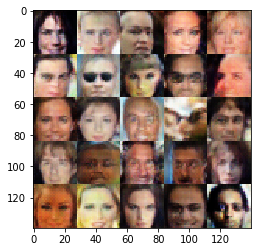

Epoch 3/3... Discriminator Loss: 1.2496... Generator Loss: 0.8697
Epoch 3/3... Discriminator Loss: 1.4111... Generator Loss: 0.5025
Epoch 3/3... Discriminator Loss: 1.4149... Generator Loss: 0.5170
Epoch 3/3... Discriminator Loss: 1.4747... Generator Loss: 0.4864
Epoch 3/3... Discriminator Loss: 1.5435... Generator Loss: 0.4486
Epoch 3/3... Discriminator Loss: 1.6084... Generator Loss: 0.3543
Epoch 3/3... Discriminator Loss: 1.1235... Generator Loss: 0.8069
Epoch 3/3... Discriminator Loss: 1.1819... Generator Loss: 0.7286
Epoch 3/3... Discriminator Loss: 1.3529... Generator Loss: 0.5337
Epoch 3/3... Discriminator Loss: 1.4791... Generator Loss: 0.4312
Epoch 3/3... Discriminator Loss: 1.5355... Generator Loss: 0.4196
Epoch 3/3... Discriminator Loss: 1.8042... Generator Loss: 0.2893
Epoch 3/3... Discriminator Loss: 1.0501... Generator Loss: 0.9327
Epoch 3/3... Discriminator Loss: 1.1452... Generator Loss: 0.7954
Epoch 3/3... Discriminator Loss: 1.8921... Generator Loss: 0.2772
Epoch 3/3.

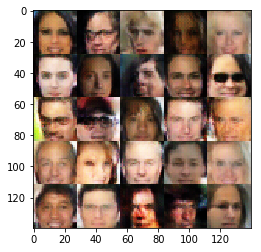

Epoch 3/3... Discriminator Loss: 1.2757... Generator Loss: 0.5824
Epoch 3/3... Discriminator Loss: 1.6202... Generator Loss: 0.3622
Epoch 3/3... Discriminator Loss: 1.0413... Generator Loss: 0.8545
Epoch 3/3... Discriminator Loss: 1.1974... Generator Loss: 0.6658
Epoch 3/3... Discriminator Loss: 1.5613... Generator Loss: 0.4131
Epoch 3/3... Discriminator Loss: 1.6025... Generator Loss: 0.3750
Epoch 3/3... Discriminator Loss: 1.4204... Generator Loss: 0.6737
Epoch 3/3... Discriminator Loss: 1.3870... Generator Loss: 0.4972
Epoch 3/3... Discriminator Loss: 1.7377... Generator Loss: 0.3224
Epoch 3/3... Discriminator Loss: 1.4185... Generator Loss: 0.4848
Epoch 3/3... Discriminator Loss: 1.2571... Generator Loss: 0.9361
Epoch 3/3... Discriminator Loss: 1.3207... Generator Loss: 0.5627
Epoch 3/3... Discriminator Loss: 1.5912... Generator Loss: 0.3802
Epoch 3/3... Discriminator Loss: 1.4231... Generator Loss: 0.5137
Epoch 3/3... Discriminator Loss: 1.3527... Generator Loss: 0.5276
Epoch 3/3.

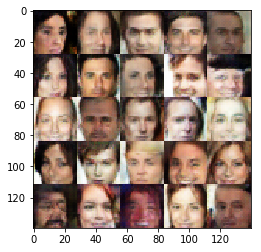

Epoch 3/3... Discriminator Loss: 1.2161... Generator Loss: 0.8923
Epoch 3/3... Discriminator Loss: 1.8168... Generator Loss: 0.3055
Epoch 3/3... Discriminator Loss: 1.4262... Generator Loss: 0.4674
Epoch 3/3... Discriminator Loss: 1.5047... Generator Loss: 0.4072
Epoch 3/3... Discriminator Loss: 1.3084... Generator Loss: 0.5823
Epoch 3/3... Discriminator Loss: 1.0666... Generator Loss: 0.8223
Epoch 3/3... Discriminator Loss: 1.9417... Generator Loss: 0.2523
Epoch 3/3... Discriminator Loss: 1.1419... Generator Loss: 0.6900
Epoch 3/3... Discriminator Loss: 1.6883... Generator Loss: 0.3303
Epoch 3/3... Discriminator Loss: 1.2365... Generator Loss: 0.7997
Epoch 3/3... Discriminator Loss: 1.1524... Generator Loss: 1.0778
Epoch 3/3... Discriminator Loss: 1.4162... Generator Loss: 0.4903
Epoch 3/3... Discriminator Loss: 1.2637... Generator Loss: 0.5500
Epoch 3/3... Discriminator Loss: 1.2601... Generator Loss: 0.6675
Epoch 3/3... Discriminator Loss: 1.0728... Generator Loss: 0.8621
Epoch 3/3.

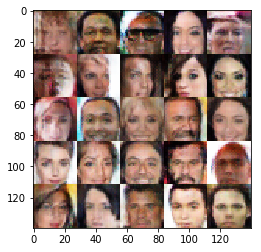

Epoch 3/3... Discriminator Loss: 1.4278... Generator Loss: 0.5523
Epoch 3/3... Discriminator Loss: 1.0742... Generator Loss: 0.8421
Epoch 3/3... Discriminator Loss: 1.3929... Generator Loss: 0.4904
Epoch 3/3... Discriminator Loss: 1.3426... Generator Loss: 0.5032
Epoch 3/3... Discriminator Loss: 1.5523... Generator Loss: 0.5120
Epoch 3/3... Discriminator Loss: 1.1429... Generator Loss: 0.7238
Epoch 3/3... Discriminator Loss: 1.4689... Generator Loss: 0.4416
Epoch 3/3... Discriminator Loss: 1.4692... Generator Loss: 0.5655
Epoch 3/3... Discriminator Loss: 1.3956... Generator Loss: 0.5172
Epoch 3/3... Discriminator Loss: 1.2461... Generator Loss: 0.7053
Epoch 3/3... Discriminator Loss: 1.2961... Generator Loss: 0.6008
Epoch 3/3... Discriminator Loss: 1.7263... Generator Loss: 0.3559
Epoch 3/3... Discriminator Loss: 1.0834... Generator Loss: 0.8538
Epoch 3/3... Discriminator Loss: 1.3131... Generator Loss: 0.5354
Epoch 3/3... Discriminator Loss: 1.2974... Generator Loss: 0.7450
Epoch 3/3.

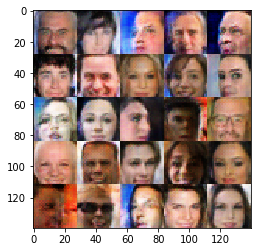

Epoch 3/3... Discriminator Loss: 1.2897... Generator Loss: 0.5774
Epoch 3/3... Discriminator Loss: 1.2069... Generator Loss: 0.6680
Epoch 3/3... Discriminator Loss: 1.7516... Generator Loss: 0.3190
Epoch 3/3... Discriminator Loss: 1.2723... Generator Loss: 0.5746
Epoch 3/3... Discriminator Loss: 1.3723... Generator Loss: 0.5625
Epoch 3/3... Discriminator Loss: 1.2368... Generator Loss: 1.0166
Epoch 3/3... Discriminator Loss: 1.1477... Generator Loss: 0.7275
Epoch 3/3... Discriminator Loss: 1.4691... Generator Loss: 0.4966
Epoch 3/3... Discriminator Loss: 1.4306... Generator Loss: 0.6678
Epoch 3/3... Discriminator Loss: 1.5431... Generator Loss: 0.4610
Epoch 3/3... Discriminator Loss: 1.2488... Generator Loss: 0.5868
Epoch 3/3... Discriminator Loss: 1.3869... Generator Loss: 0.4790
Epoch 3/3... Discriminator Loss: 1.4667... Generator Loss: 0.4407
Epoch 3/3... Discriminator Loss: 2.0775... Generator Loss: 0.2363
Epoch 3/3... Discriminator Loss: 1.9042... Generator Loss: 0.2800
Epoch 3/3.

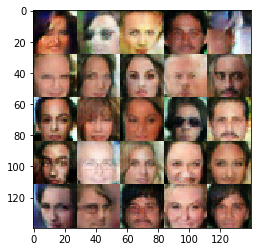

Epoch 3/3... Discriminator Loss: 1.0927... Generator Loss: 1.8613
Epoch 3/3... Discriminator Loss: 1.3571... Generator Loss: 0.5405
Epoch 3/3... Discriminator Loss: 1.2219... Generator Loss: 0.8441
Epoch 3/3... Discriminator Loss: 1.5657... Generator Loss: 0.3844
Epoch 3/3... Discriminator Loss: 1.3714... Generator Loss: 0.5581
Epoch 3/3... Discriminator Loss: 1.1079... Generator Loss: 0.9755
Epoch 3/3... Discriminator Loss: 1.4161... Generator Loss: 0.4675
Epoch 3/3... Discriminator Loss: 1.4257... Generator Loss: 0.4503
Epoch 3/3... Discriminator Loss: 1.2212... Generator Loss: 0.7271
Epoch 3/3... Discriminator Loss: 1.1183... Generator Loss: 1.4882
Epoch 3/3... Discriminator Loss: 1.8788... Generator Loss: 0.2740
Epoch 3/3... Discriminator Loss: 1.2790... Generator Loss: 0.8886
Epoch 3/3... Discriminator Loss: 1.8053... Generator Loss: 0.3188
Epoch 3/3... Discriminator Loss: 1.0737... Generator Loss: 0.9918
Epoch 3/3... Discriminator Loss: 1.2340... Generator Loss: 0.7058
Epoch 3/3.

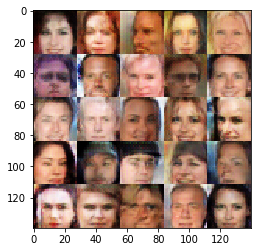

Epoch 3/3... Discriminator Loss: 1.2911... Generator Loss: 0.6194
Epoch 3/3... Discriminator Loss: 1.0537... Generator Loss: 0.9144
Epoch 3/3... Discriminator Loss: 1.9279... Generator Loss: 0.2596
Epoch 3/3... Discriminator Loss: 1.5536... Generator Loss: 0.4252
Epoch 3/3... Discriminator Loss: 0.9481... Generator Loss: 0.9312
Epoch 3/3... Discriminator Loss: 1.1923... Generator Loss: 0.6650
Epoch 3/3... Discriminator Loss: 1.2375... Generator Loss: 0.6272
Epoch 3/3... Discriminator Loss: 1.5528... Generator Loss: 0.4845
Epoch 3/3... Discriminator Loss: 1.7729... Generator Loss: 0.3056


In [15]:
batch_size = 64
z_dim = 128
learning_rate = 0.0004
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.